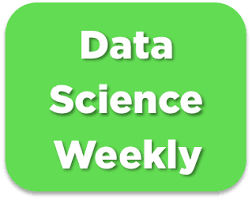

# Challenge : predict conversion rate 🏆🏆

Goal: 
* Create a model that has the best F1 score

# Import libraries

In [4]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE


# Loading & exploring dataset

In [5]:
data = pd.read_csv('Data/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [6]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [8]:
data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [7]:
# Because the dataset is so large, we'll sample it before creating any visualizations
data_sample = data.sample(10000)

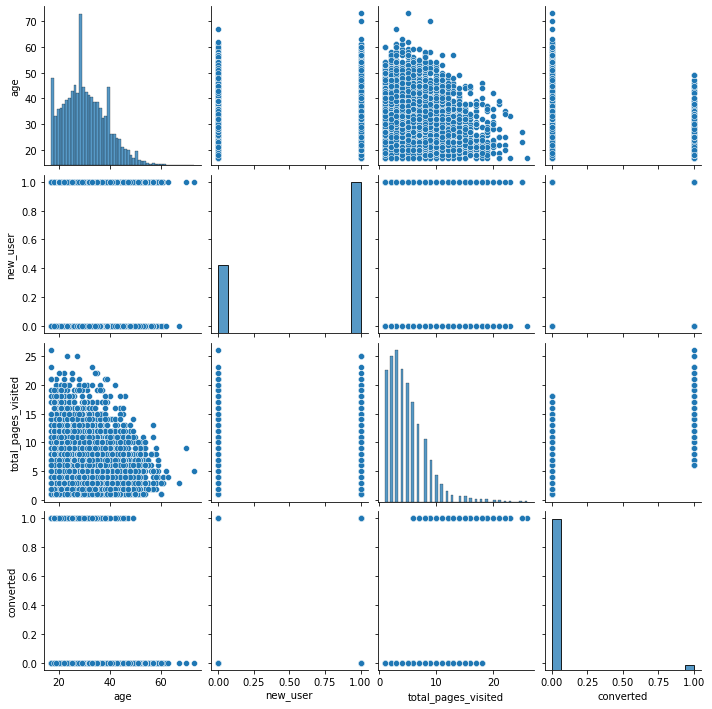

In [9]:
sns.pairplot(data_sample)

In [10]:
fig = px.scatter(y=data_sample['country'],x=data_sample['age'],color=data_sample['converted'])
fig.show()

In [11]:
#Looked above like UK & Germany had somewhat higher conversion rates than China for instance, let's have a closer look at the numbers
country_grouped = data.groupby('country')['country','converted'].agg({'converted':['sum','count']})
country_grouped.columns = [ '_'.join(x) for x in country_grouped.columns ] #getting rid of multiindex and concatenating previous column name with function
country_grouped['Proportion'] = country_grouped['converted_sum'] * 100 /country_grouped['converted_count'] 
country_grouped.sort_values('Proportion',ascending=False)

<ipython-input-11-42409883926d>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,converted_sum,converted_count,Proportion
country,,,
Germany,730,11693,6.243051
UK,2291,43641,5.249651
US,6070,160124,3.790812
China,89,69122,0.128758


Looks like the country feature would be a good fit in our model as Germany/UK indeed have significantly higher conversion rate than that of China

In [12]:
fig = px.histogram(data_sample, x="age",width=800, height=400)
fig.show()

In [13]:
bins = pd.cut(data['age'], [17, 20, 25, 30, 35, 40,50,65])
age_df = data.groupby(bins)['age','converted'].agg(['count', 'sum'])
age_df['Conversion Rate'] = age_df[('converted',   'sum')] * 100 / age_df[(      'age', 'count')]
age_df

<ipython-input-13-a23811e83fa0>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



age          converted       Conversion Rate
          count      sum     count   sum                
age                                                     
(17, 20]  25245   481124     25245  1508        5.973460
(20, 25]  55242  1276316     55242  2621        4.744578
(25, 30]  63831  1788172     63831  2142        3.355736
(30, 35]  57093  1878919     57093  1347        2.359308
(35, 40]  40302  1523612     40302   687        1.704630
(40, 50]  31818  1405767     31818   357        1.122006
(50, 65]   4199   226217      4199    21        0.500119

Age seems to be a strong feature as well - the younger the individual is the most likely he/she is to subscribe

In [ ]:
fig = px.Scatter(data_sample, x="total_pages_visited",y='converted',width=800, height=400)
fig.show()

# Machine Learning

## Selected features

From the EDA, we know that the most useful feature are total_pages_visited, age and country. We'll start by doing models with only those features.

In [ ]:
data.columns

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [15]:
features_list = ['country','age','total_pages_visited']
numeric_indices = [1,2]
categorical_indices = [0]
target_variable = 'converted'

In [16]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'total_pages_visited'], dtype='object')



In [17]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1,stratify = Y, random_state=42)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [18]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[['China' 30 8]
 ['Germany' 43 5]
 ['US' 41 2]
 ['UK' 29 19]
 ['US' 49 4]]
[['US' 20 5]
 ['China' 28 2]]

[0 0 0 1 0]
[0 0]


## Training pipeline

In [19]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

In [20]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")
X_train = preprocessor.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.06766859  0.93587807  0.          0.          0.        ]
 [ 1.50460508  0.03801145  1.          0.          0.        ]
 [ 1.26271682 -0.85985517  0.          0.          1.        ]
 [-0.18861272  4.22805567  0.          1.          0.        ]
 [ 2.23026985 -0.26127743  0.          0.          1.        ]]


In [21]:
# Do same for test straight away
X_test = preprocessor.transform(X_test)
print(X_test[0:5,:])

[[-1.27710987  0.03801145  0.          0.          1.        ]
 [-0.30955685 -0.85985517  0.          0.          0.        ]
 [-1.398054    0.63658919  0.          0.          0.        ]
 [ 1.86743746  0.63658919  0.          0.          1.        ]
 [-1.63994226 -0.5605663   0.          0.          1.        ]]


## Model 1 - Logistic Regression

In [22]:
# Model 1 
print("Train model...")
classifier = LogisticRegression() # 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [23]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [24]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



-- Performance Assessment

In [25]:
model1_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.732658366397592
f1-score on test set :  0.7326732673267328


In [26]:
# Printing Confusion Matrix
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246859   1001]
 [  2907   5355]]

Confusion matrix on test set : 
[[27434   106]
 [  326   592]]



## Model 2 - Decision Tree

In [27]:
# Model 2 -- 
print("Train model...")
grid_search = GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': np.array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': [2, 5, 10]})
grid_search.fit(X_train,Y_train)
print("...Done.")

Train model...
...Done.


In [28]:
# Predictions on training set -- MODEL 2 
print("Predictions on training set...")
Y_train_pred = grid_search.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [29]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = grid_search.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [30]:
grid_search.best_params_

{'max_depth': 8, 'min_samples_split': 10}

 -- Performance assessment

In [31]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
model2_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7375800471857095
f1-score on test set :  0.7292682926829268


In [32]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246758   1102]
 [  2791   5471]]

Confusion matrix on test set : 
[[27416   124]
 [  320   598]]



# Model 3


Do not run the below again - takes a very long time -- been put on markdown to avoid. Best params it found fom the below are {'learning_rate': 1.0, 'n_estimators': 200}

```python
grid = GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [2.0, 1.5, 1.0, 0.5, 0.1],
                         'n_estimators': [50, 100, 150, 200, 300]},
                    cv=3, #save some time
                   verbose=2)
grid.fit(X_train,Y_train) ```

grid = GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [2.0, 1.5, 1.0, 0.5, 0.1],
                         'n_estimators': [50, 100, 150, 200, 300]},
                    cv=3, #save some time
                   verbose=2)
grid.fit(X_train,Y_train)

In [33]:
grid = AdaBoostClassifier(learning_rate = 1, n_estimators = 200)
grid.fit(X_train,Y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=200)

In [34]:
# Predictions on training set -- MODEL 3 
print("Predictions on training set...")
Y_train_pred = grid.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = grid.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

model3_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

f1-score on train set :  0.7350565428109854
f1-score on test set :  0.7321212121212121


# Testing Models with all of the data

## Model 4 

In [35]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [36]:
features_list = ['country','age','new_user','source','total_pages_visited']
numeric_indices = [1,2,4]
categorical_indices = [0,3]

#Separating features & target
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()
print('Target : ',target_variable)

# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,stratify = Y, random_state=42)
print("...Done.")
print()

#Pipeline didn't change aside from num_indices/ categorical_indices
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

# Preprocessing
print("Encoding categorical features and standardizing numerical features...")
X_train = preprocessor.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])
X_test = preprocessor.transform(X_test)


Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')

Target :  converted
Dividing into train and test sets...
...Done.

Encoding categorical features and standardizing numerical features...
...Done
[[-1.27650481  0.6761303  -0.2618471   0.          0.          1.
   0.          0.        ]
 [-0.18867057  0.6761303  -0.56090876  0.          0.          0.
   0.          0.        ]
 [ 0.65742272 -1.47900486 -0.56090876  0.          0.          1.
   0.          1.        ]
 [-0.9138934   0.6761303   0.93439955  0.          0.          1.
   0.          1.        ]
 [ 1.26177508  0.6761303  -0.56090876  0.          1.          0.
   0.          0.        ]]


In [37]:
# Model 4 
print("Train model...")
grid_search = GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': np.array([1, 2, 3, 4,5,6,7,8,9]),
                         'min_samples_split': [2, 5, 10]})
grid_search.fit(X_train,Y_train)
print("...Done.")

Train model...
...Done.


In [38]:
# Predictions on training set -- MODEL 4 
print("Predictions on training set...")
Y_train_pred = grid_search.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()


Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [39]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = grid_search.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [40]:
grid_search.best_params_

{'max_depth': 9, 'min_samples_split': 5}

Get Scores

In [41]:
model4_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7706877113866967
f1-score on test set :  0.7582251735587081


In [42]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[219486    834]
 [  2217   5127]]

Confusion matrix on test set : 
[[54859   221]
 [  580  1256]]



## Model 5 - Logistic on whole dataset

In [43]:
print("Train model...")
classifier = LogisticRegression() # 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [44]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [45]:
model5_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7620556939098936
f1-score on test set :  0.7682520448348984


In [46]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[219462    858]
 [  2295   5049]]

Confusion matrix on test set : 
[[54883   197]
 [  568  1268]]



# Model 6 - XGB Boost on whole dataset with default parameters

In [47]:
XGBreg = XGBClassifier()
XGBreg.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [48]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = XGBreg.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = XGBreg.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [49]:
model6_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.774125926480497
f1-score on test set :  0.7645645645645646


# Model 7 - XGB Boost on whole dataset with parameters found in grid search on model 3

In [50]:
XGBreg = XGBClassifier(learning_rate =  1.0, n_estimators = 200)
XGBreg.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=1.0, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [51]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = XGBreg.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = XGBreg.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [52]:
model7_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7935083389424874
f1-score on test set :  0.7445652173913043


# Model 8 - ADABOOST with logistic regression
Bc so far simple logistic model is the one to beat

In [53]:
model8 = AdaBoostClassifier(base_estimator=LogisticRegression())
model8

AdaBoostClassifier(base_estimator=LogisticRegression())

In [54]:
model8.fit(X_train,Y_train,sample_weight=None)

AdaBoostClassifier(base_estimator=LogisticRegression())

In [55]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model8.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model8.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [56]:
model8_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7517461281506226
f1-score on test set :  0.7545203800183878


# Model 9 - GridSearch, with same basis as model above (ADABoost with logistic regression) 
This time for learning rate & n_estimators bc in model 3 was at the edge of the range, when further to this range

In [57]:
model9 = GridSearchCV(estimator=AdaBoostClassifier(base_estimator=LogisticRegression()),
             param_grid={'learning_rate': [2.5,2, 1.5, 1.0],
                         'n_estimators': [ 200, 300]},
                    cv=3, #save some time
                   verbose=2)
model9.fit(X_train,Y_train) 
model9.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] learning_rate=2.5, n_estimators=200 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. learning_rate=2.5, n_estimators=200, total=17.9min
[CV] learning_rate=2.5, n_estimators=200 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 17.9min remaining:    0.0s


[CV] .............. learning_rate=2.5, n_estimators=200, total= 4.9min
[CV] learning_rate=2.5, n_estimators=200 .............................
[CV] .............. learning_rate=2.5, n_estimators=200, total= 4.5min
[CV] learning_rate=2.5, n_estimators=300 .............................
[CV] .............. learning_rate=2.5, n_estimators=300, total=28.6min
[CV] learning_rate=2.5, n_estimators=300 .............................
[CV] .............. learning_rate=2.5, n_estimators=300, total=36.4min
[CV] learning_rate=2.5, n_estimators=300 .............................
[CV] .............. learning_rate=2.5, n_estimators=300, total= 8.2min
[CV] learning_rate=2, n_estimators=200 ...............................
[CV] ................ learning_rate=2, n_estimators=200, total= 2.4min
[CV] learning_rate=2, n_estimators=200 ...............................
[CV] ................ learning_rate=2, n_estimators=200, total= 2.1min
[CV] learning_rate=2, n_estimators=200 ...............................
[CV] .

KeyboardInterrupt: 

In [ ]:
# Just saving down the best params of above to save time on not running grid search again
model9 = AdaBoostClassifier(base_estimator=LogisticRegression(),learning_rate=1.5,n_estimators=200)
model9.fit(X_train,Y_train) 

AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=1.5,
                   n_estimators=200)

#Try above with new parameters before leaving

In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model9.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model9.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [ ]:
model9_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7610485759613205
f1-score on test set :  0.7645092676997874


# Model 10 - Voting

In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

model10 = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
model10.fit(X_train, Y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('gnb', GaussianNB())])

In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model10.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model10.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [ ]:
model10_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.78397898883782
f1-score on test set :  0.7693208430913349


# Model 11 - Voting soft

In [ ]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

model11 = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
model11.fit(X_train, Y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('gnb', GaussianNB())],
                 voting='soft')

In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model11.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model11.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [ ]:
model11_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7860927633011541
f1-score on test set :  0.7695004382120947


# Model 12 - Voting soft & XGB boost

In [ ]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
clf4 = XGBClassifier()

model12 = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2),('Gaus',clf3),('XGB',clf4)], voting='hard')
model12.fit(X_train, Y_train)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[13:49:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('lr',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('Gaus', GaussianNB()),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            impo...
                                            interaction_constraints=None,
            

In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model12.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model12.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [ ]:
model12_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7750807845494851
f1-score on test set :  0.7664057796508127


# Model 14

In [ ]:
from sklearn.decomposition import PCA

# initiate PCA and classifier
pca = PCA()
classifier = LogisticRegression()

# transform / fit

X_train_PCA = pca.fit_transform(X_train)
classifier.fit(X_transformed, Y_train)

# transform new data using already fitted pca
# (don't re-fit the pca)
X_test_PCA = pca.transform(X_test)

# predict labels using the trained classifier

Y_train_pred = classifier.predict(X_train_PCA)
Y_test_pred = classifier.predict(X_test_PCA)

In [ ]:
model14_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set: ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set:  0.7620556939098936
f1-score on test set :  0.7682520448348984


# Model 16 - PCA with voting

In [ ]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=150, random_state=1)
clf3 = GaussianNB()


model16 = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2),('Gaus',clf3)], voting='soft')

model16.fit(X_train_PCA, Y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=150,
                                                     random_state=1)),
                             ('Gaus', GaussianNB())],
                 voting='soft')

In [ ]:
Y_train_pred = classifier.predict(X_train_PCA)
Y_test_pred = classifier.predict(X_test_PCA)

model16_test_score = f1_score(Y_test, Y_test_pred)
print("f1-score on train set: ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set:  0.7620556939098936
f1-score on test set :  0.7682520448348984


# Comparing the Scores on all of the models

In [ ]:
print('Comparing test scores')
print()
print('-- Models on not all of the data:')
print()
print('Model 1 test score:',model1_test_score)
print('Model 2 test score:',model2_test_score)
print('Model 3 test score:',model3_test_score)
print()
print("-- Models on whole dataset:")
print()
print('Model 4 test score:',model4_test_score) 
print('Model 5 test score:',model5_test_score)
print('Model 6 test score:',model6_test_score)
print('Model 7 test score:',model7_test_score)
print('Model 8 test score:',model8_test_score)
print('Model 10 test score:',model10_test_score)
print('Model 11 test score:',model11_test_score) 
print('Model 12 test score:',model12_test_score)
print('Model 14 test score:',model14_test_score)


Comparing test scores

-- Models on not all of the data:

Model 1 test score: 0.7326732673267328
Model 2 test score: 0.7292682926829268
Model 3 test score: 0.7321212121212121

-- Models on whole dataset:

Model 4 test score: 0.7582251735587081
Model 5 test score: 0.7682520448348984
Model 6 test score: 0.7645645645645646
Model 7 test score: 0.7445652173913043
Model 8 test score: 0.7545203800183878
Model 10 test score: 0.7693208430913349
Model 11 test score: 0.7695004382120947
Model 12 test score: 0.7664057796508127
Model 14 test score: 0.7682520448348984


# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
X_train

,country,age,new_user,source,total_pages_visited
137434,China,19,1,Seo,1
112323,US,33,1,Direct,5
143261,US,51,1,Ads,2
162328,China,17,0,Seo,1
158039,China,28,1,Seo,5
...,...,...,...,...,...
132514,US,29,0,Seo,15
243326,China,45,0,Seo,3
136997,US,31,0,Ads,1
70286,UK,27,0,Ads,9


In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train_PCA,X_test_PCA,axis=0)
Y = np.append(Y_train,Y_test)


clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

model11 = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
model11.fit(X, Y)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('gnb', GaussianNB())],
                 voting='soft')

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)


# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['country','age','new_user','source','total_pages_visited']
numeric_indices = [1,2,4]
categorical_indices = [0,3]

#Separating features & target
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()
print('Target : ',target_variable)

# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,stratify = Y, random_state=0)
print("...Done.")
print()

"""#Pipeline didn't change aside from num_indices/ categorical_indices
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])
"""
# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')

Target :  converted
Dividing into train and test sets...
...Done.

Convert pandas DataFrames to numpy arrays...
...Done
[['UK' 28 0 'Seo' 16]
 ['UK' 22 1 'Direct' 5]
 ['China' 32 1 'Seo' 1]
 ['US' 32 1 'Ads' 6]
 ['China' 25 0 'Seo' 3]]


In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
X_without_labels = pca.transform(X_without_labels)


print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...


NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
model11.predict(X_without_labels)

array([1, 0, 0, ..., 0, 1, 0])

In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': model11.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_Lea_Boussekeyt-model4.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**